# ECG analysis project
#### Author: Marian Petruk


### Import libraries, modules

In [73]:
import numpy as np
np.random.seed(256)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample

from utils import hamilton_detector, christov_detector, findpeaks, engzee_detector
from ecg_detectors.ecgdetectors import Detectors, MWA, panPeakDetect, searchBack

### Traverse data directory

In [59]:
import os
data_path = os.path.join("data", "Lviv-Biometric-Data-Set")
data_dirs = os.listdir(data_path)
data_dirs.remove('LICENSE')
data_dirs.remove("README.md")
print(len(data_dirs),"users = ", data_dirs)

USERID = 1
user_path = os.path.join(data_path, "user" + str(USERID))

user_ecg = os.listdir(user_path)
print("\nuser" + str(USERID), "has", len(user_ecg), "ecg samples =", user_ecg)

18 users =  ['user1', 'user10', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16', 'user17', 'user18', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9']

user1 has 7 ecg samples = ['user1_02_26_16_42.npy', 'user1_02_29_18_37.npy', 'user1_02_29_18_38.npy', 'user1_03_09_18_16.npy', 'user1_03_10_11_14.npy', 'user1_03_10_15_09.npy', 'user1_03_10_15_10.npy']


### Load raw ECG signal

In [256]:
SAMPLEID = 0
data = np.load(os.path.join(user_path, user_ecg[SAMPLEID]))
print(type(data))
print(data)
print(data.shape)

<class 'numpy.ndarray'>
[6038. 6046. 6446. ... 7337. 7206. 6917.]
(3000,)


### Plot raw ecg sample

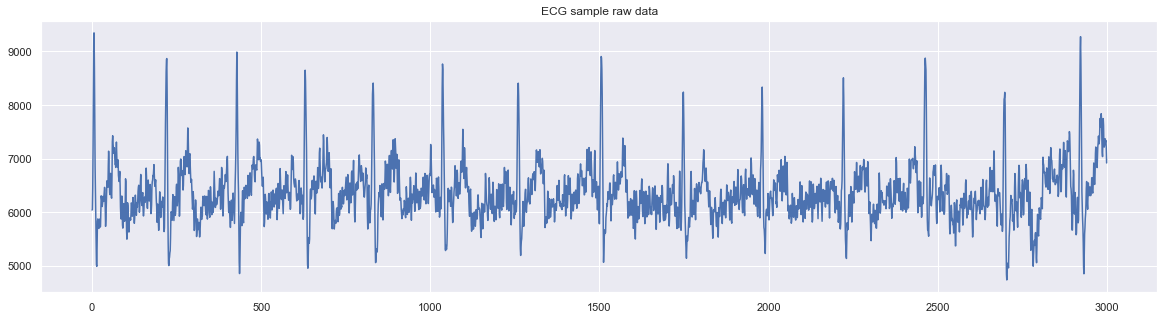

In [257]:
plt.figure(figsize=(20, 5))
plt.plot(data)
plt.title('ECG sample raw data')
plt.show()

### Filter the data from noice

#### **Butterworth Bandpass filter**

In [258]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data) # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
        return y

def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi*data[0])
    return sos, z, zi

def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi*z[0])
    return z2
    

def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data) # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
        return y

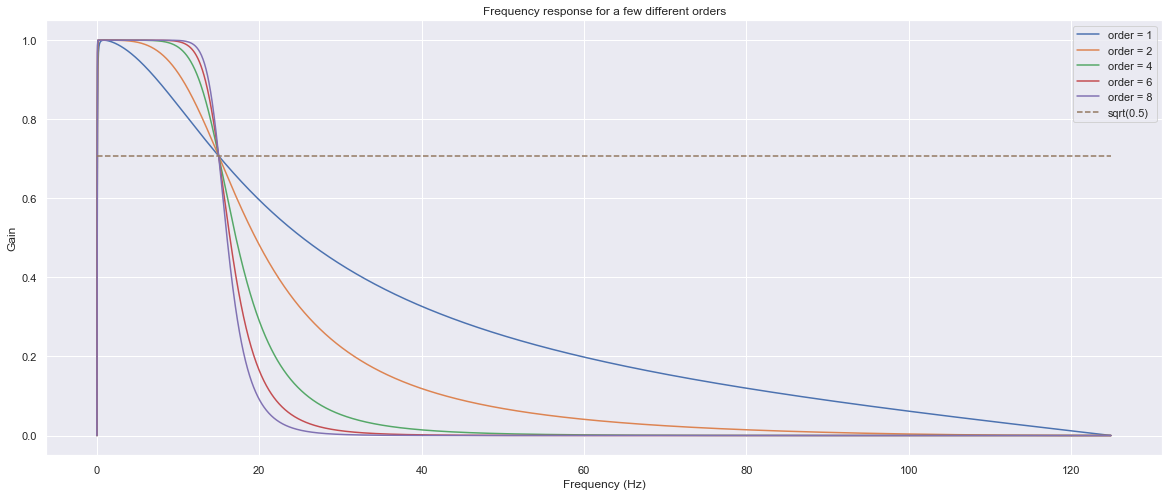

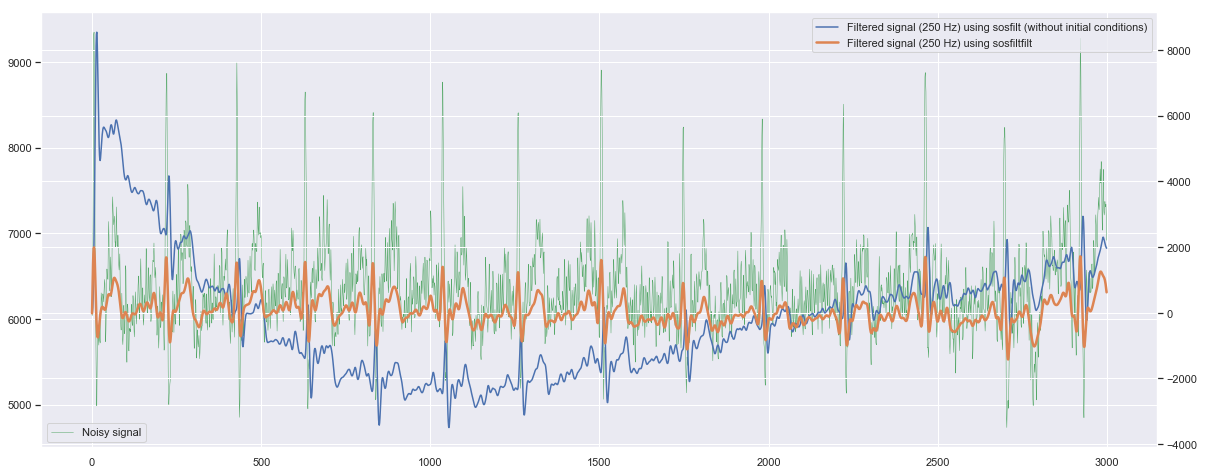

In [259]:


# Sample rate and desired cutoff frequencies (in Hz).
x = data
fs = 250
lowcut = 0.05
highcut = 15

# fs = 768
# x = resample(data, fs)
# data = resample(data, fs)
# lowcut = 10
# highcut = 200


# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency response for a few different orders')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.

# T = 0.05
# nsamples = T * fs
# t = np.linspace(0, T, nsamples, endpoint=False)

plt.figure(2, figsize=(20, 8))
plt.clf()
plt.plot(x, 'g', linewidth=0.5, label='Noisy signal')
plt.legend(loc='lower left')
plt.twinx()
plt.plot(butter_bandpass_filter(x, lowcut, highcut, fs, order=4), label='Filtered signal (%g Hz) using sosfilt (without initial conditions)' % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(y, linewidth=2.5, label='Filtered signal (%g Hz) using sosfiltfilt' % fs)

# plt.twiny()
# plt.plot(butter_bandpass_forward_backward_filter(data, 0.05, 15, 250, order=4), linewidth=2, label='Filtered signal (%g Hz) using sosfiltfilt' % fs)

plt.xlabel('time')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper right')

plt.show()

As we can see, it is better using `scipy.signal.sosfiltfilt` instead of `sosfilt` to apply the Butterworth filter. `sosfiltfilt` is the forward-backward filter. It applies the filter twice, once forward and once backward, resulting in zero phase delay.

#### Illustration of a phase delay/shift

Phase shift is any change that occurs in the phase of one quantity, or in the phase difference between two or more quantities. (c) Wikipedia 
<img width="300px" src="images/Phase_shift.png" alt="illustration of phase shift from wikipedia">

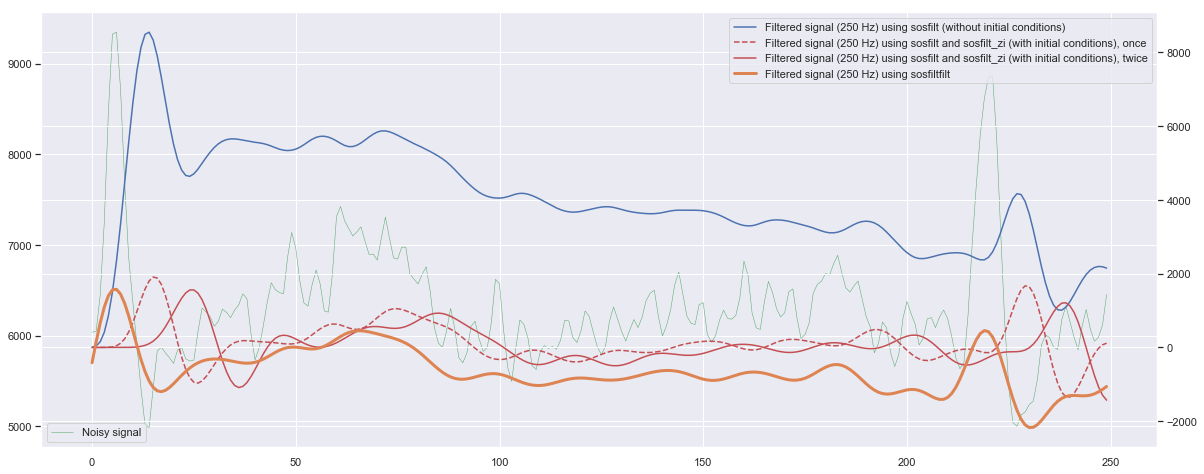

In [260]:
x = data[:fs]
plt.figure(figsize=(20,8))
plt.plot(x, 'g', linewidth=0.5, label='Noisy signal')
plt.legend(loc='lower left')
plt.twinx()
plt.plot(butter_bandpass_filter(x, lowcut, highcut, fs, order=4), label='Filtered signal (%g Hz) using sosfilt (without initial conditions)' % fs)
sos, z, zi = butter_bandpass_filter_once(x, lowcut, highcut, fs, order=5)
plt.plot(z, 'r--', label='Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), once' % fs)
plt.plot(butter_bandpass_filter_again(sos, z, zi), 'r', label='Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), twice' % fs)
plt.plot(butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4), linewidth=3, label='Filtered signal (%g Hz) using sosfiltfilt' % fs)
plt.xlabel('time')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper right')

plt.show()

We can see phase delay on filtered singal using `sosfilt` without initial conditions and on both stages of `sosfilt` with initial conditions (`sosfilt_zi`). However, `sosfiltfilt` - a forward-backward digital filter has **zero phase delay/shift**.

## QRS

QRS detection is difficult, not only because of the physiological variability of the QRS complexes, but also because of the various types of noise that can be present in the ECG signal. Noise sources include muscle noise, artifacts due to electrode motion, power-line interference, baseline wander and T waves with high frequency characteristics similar to QRS complexes.

### Detect R-peaks

#### Main detector that is used is pan-tompkins

In [261]:
def pan_tompkins_detector(raw_ecg, mwa, fs, N):
   
#     N = int(0.12 * fs)
#     mwa = MWA(squared, N)
#     mwa[:int(0.2 * fs)] = 0

    N = int(N / 100 * fs)
    mwa_peaks = panPeakDetect(mwa, fs)

    r_peaks = searchBack(mwa_peaks, raw_ecg, N)

    return r_peaks

In [262]:
# Derivative - provides QRS slope information.
differentiated_ecg_measurements = np.ediff1d(y)

# Squaring - intensifies values received in derivative. 
#This helps restrict false positives caused by T waves with higher than usual spectral energies..
squared_ecg_measurements = differentiated_ecg_measurements ** 2

# Moving-window integration.
integration_window = 50 # Change proportionally when adjusting frequency (in samples)
integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

# Fiducial mark - peak detection on integrated measurements.
rpeaks = pan_tompkins_detector(data, integrated_ecg_measurements, fs, integration_window)
print(rpeaks)

[   6  221  221  428  428  630  831 1036 1260 1505 1748 1981 2221 2463
 2698 2922]


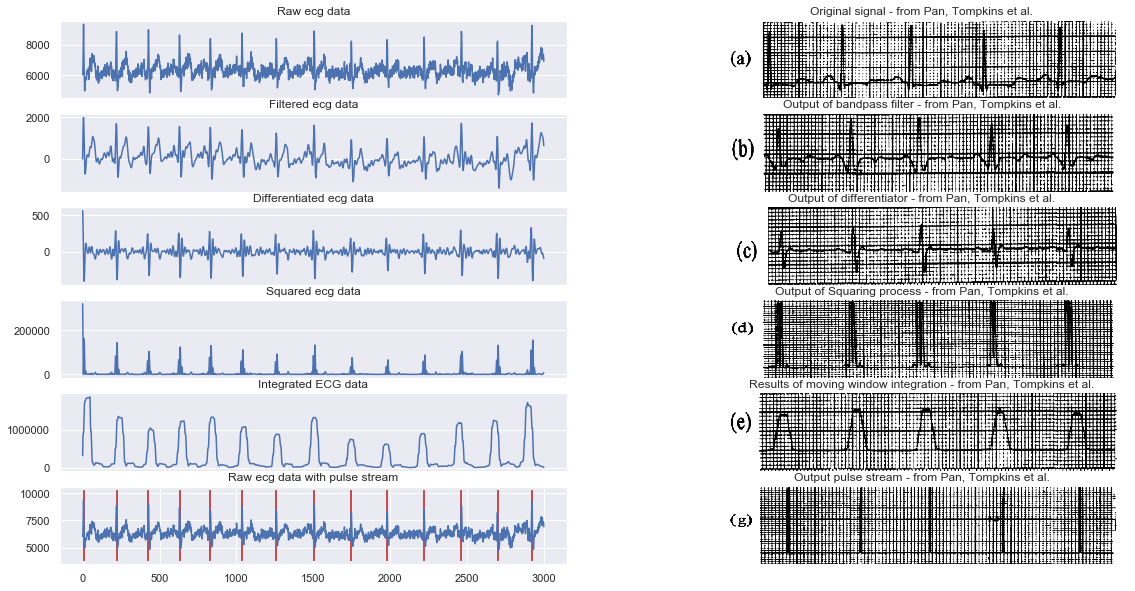

In [263]:
figsize = (20, 10)

plt.figure(figsize=figsize)

plt.subplot2grid((6, 2), (0, 0))
# plt.subplot(621)
# plt.figure(1, figsize=left_figsize)
# plt.clf()
plt.xticks([])
plt.plot(data)
plt.title('Raw ecg data')
plt.grid(True)
# plt.show()

# plt.figure(figsize=left_figsize)
plt.subplot2grid((6, 2), (1, 0))
# plt.subplot(622)
# plt.clf()
plt.xticks([])
plt.plot(y)
plt.title('Filtered ecg data')
plt.grid(True)
# plt.show()

# plt.figure(figsize=left_figsize)
plt.subplot2grid((6,2), (2, 0))
# plt.subplot(623)
# plt.clf()
plt.xticks([])
plt.plot(differentiated_ecg_measurements)
plt.title('Differentiated ecg data')
plt.grid(True)
# plt.show()

# plt.figure(figsize=left_figsize)
plt.subplot2grid((6,2), (3, 0))
# plt.subplot(624)
# plt.clf()
plt.xticks([])
plt.plot(squared_ecg_measurements)
plt.title('Squared ecg data')
plt.grid(True)
# plt.show()

# plt.figure(figsize=left_figsize)
plt.subplot2grid((6,2), (4, 0))
# plt.subplot(625)
# plt.clf()
plt.xticks([])
plt.plot(integrated_ecg_measurements)
plt.title('Integrated ECG data')
plt.grid(True)
# plt.show()


ymin = np.min(data)
ymax = np.max(data)
alpha = 0.2 * (ymax - ymin)
ymax += alpha
ymin -= alpha

# plt.figure(figsize=left_figsize)
# plt.subplot(626)
plt.subplot2grid((6,2), (5, 0))
# plt.clf()
plt.plot(data)
plt.vlines(rpeaks, ymin, ymax,
               color='r',
               linewidth=2,
               label='R-peaks')
plt.title('Raw ecg data with pulse stream')
plt.grid(True)
# plt.show()

plt.subplot2grid((6, 2), (0, 1))
pan_tompkins_fig1_a = mpimg.imread('images/a_original_signal.png')
plt.title("Original signal - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_a)

plt.subplot2grid((6, 2), (1, 1))
pan_tompkins_fig1_b = mpimg.imread('images/b_output_of_bandpass_filter.png')
plt.title("Output of bandpass filter - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_b)

plt.subplot2grid((6, 2), (2, 1))
pan_tompkins_fig1_c = mpimg.imread('images/c_ouput_of_differentiator.png')
plt.title("Output of differentiator - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_c)

plt.subplot2grid((6, 2), (3, 1))
pan_tompkins_fig1_d = mpimg.imread('images/d_output_of_squaring_process.png')
plt.title("Output of Squaring process - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_d)

plt.subplot2grid((6, 2), (4, 1))
pan_tompkins_fig1_e = mpimg.imread('images/e_results_of_moving_window_integration.png')
plt.title("Results of moving window integration - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_e)

plt.subplot2grid((6, 2), (5, 1))
pan_tompkins_fig1_g = mpimg.imread('images/g_output_pulse_stream.png')
plt.title("Output pulse stream - from Pan, Tompkins et al.")
plt.axis('off')
plt.imshow(pan_tompkins_fig1_g)

### Compare with other detectors

In [264]:
hamilton_rpeaks = hamilton_detector(data, fs, y)
christov_rpeaks = christov_detector(fs, data)
detected_peaks_indices = findpeaks(data=integrated_ecg_measurements, limit=0.35, spacing=100)
engzee_rpeaks = engzee_detector(y, fs, data)
# detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]


detectors = Detectors(fs)

detectors_two_average_rpeaks = detectors.two_average_detector(data)
detectors_matched_filter_rpeaks = detectors.matched_filter_detector(data)
detectors_swt_rpeaks = detectors.swt_detector(data)
detectors_christov_rpeaks = detectors.christov_detector(data)
detectors_hamilton_rpeaks = detectors.hamilton_detector(data)
detector_engzee_rpeaks = detectors.engzee_detector(data)

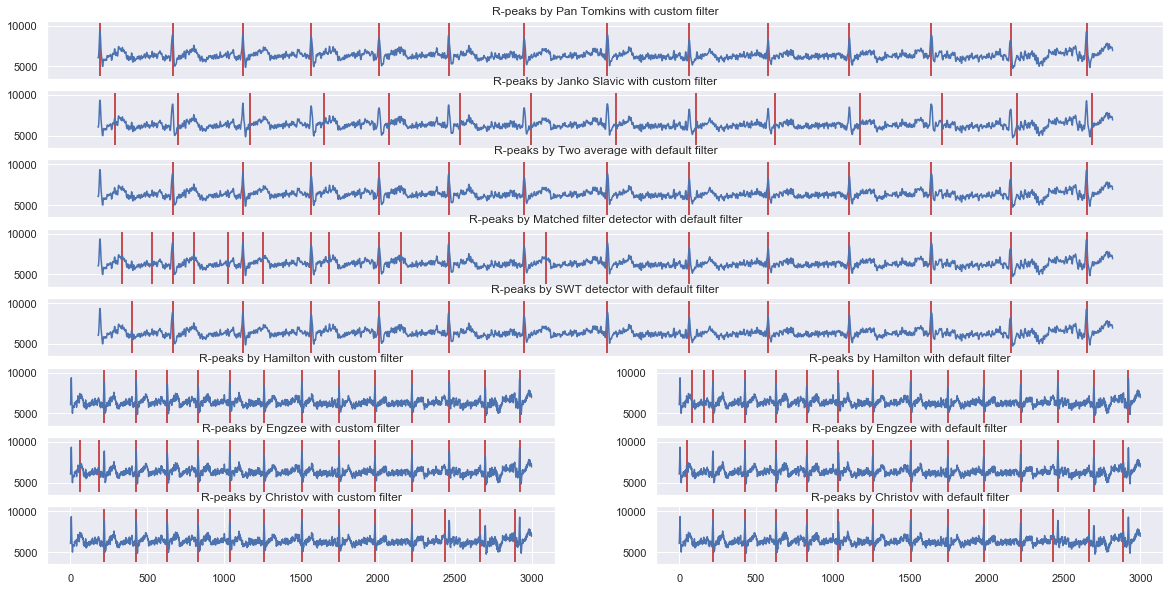

In [265]:
figsize = (20, 10)

plt.figure(figsize=figsize)

ymin = np.min(data)
ymax = np.max(data)
alpha = 0.2 * (ymax - ymin)
ymax += alpha
ymin -= alpha

grid = (8, 2)

index = 0

plt.subplot2grid(grid, (index, 0), colspan = 2)
plt.xticks([])
plt.plot(data)
plt.vlines(rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Pan Tomkins with custom filter')
plt.grid(True)

index += 1

plt.subplot2grid(grid, (index, 0), colspan = 2)
plt.xticks([])
plt.plot(data)
plt.vlines(detected_peaks_indices, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Janko Slavic with custom filter')
plt.grid(True)

index += 1

plt.subplot2grid(grid, (index, 0), colspan = 2)
plt.xticks([])
plt.plot(data)
plt.vlines(detectors_two_average_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Two average with default filter')
plt.grid(True)

index += 1

plt.subplot2grid(grid, (index, 0), colspan = 2)
plt.xticks([])
plt.plot(data)
plt.vlines(detectors_matched_filter_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Matched filter detector with default filter')
plt.grid(True)


index += 1

plt.subplot2grid(grid, (index, 0), colspan = 2)
plt.xticks([])
plt.plot(data)
plt.vlines(detectors_swt_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by SWT detector with default filter')
plt.grid(True)




index += 1

plt.subplot2grid(grid, (index, 0))
plt.plot(data)
plt.xticks([])
plt.vlines(hamilton_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Hamilton with custom filter')
plt.grid(True)

plt.subplot2grid(grid, (index, 1))
plt.plot(data)
plt.xticks([])
plt.vlines(detectors_hamilton_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Hamilton with default filter')
plt.grid(True)


index += 1


plt.subplot2grid(grid, (index, 0))
plt.plot(data)
plt.xticks([])
plt.vlines(engzee_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Engzee with custom filter')
plt.grid(True)

plt.subplot2grid(grid, (index, 1))
plt.plot(data)
plt.xticks([])
plt.vlines(detector_engzee_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Engzee with default filter')
plt.grid(True)




index += 1

plt.subplot2grid(grid, (index, 0))
plt.plot(data)
plt.vlines(christov_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Christov with custom filter')
plt.grid(True)


plt.subplot2grid(grid, (index, 1))
plt.plot(data)
plt.vlines(detectors_christov_rpeaks, ymin, ymax,
               color='r',
               linewidth=2)
plt.title('R-peaks by Christov with default filter')
plt.grid(True)

### RR-intervals (aka NN-intervals)

The term **`NN`** is used in place of **RR** to emphasize the fact that the processed beats are "normal" beats. (с) Wikipedia

Heart rate variability (HRV) is the physiological phenomenon of variation in the time interval between heartbeats. It is measured by the variation in the beat-to-beat interval.

In [266]:
# rr = []
# i = 1
# while i < len(rpeaks):
#     rr.append(rpeaks[i] - rpeaks[i-1])
#     i = i + 1
# print(rr)
rr = np.diff(rpeaks)
print(rr)

[215   0 207   0 202 201 205 224 245 243 233 240 242 235 224]


In [267]:
# RMSSD ("root mean square of successive differences"), the square root of the mean of the squares of the successive differences between adjacent NNs.
rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
print("RMSSD =", rmssd)

# Mean RR
mean_rr = np.mean(rr)
print("Mean RR =", mean_rr)

# SDNN, the standard deviation of NN intervals. Often calculated over a 24-hour period.
# SDANN, the standard deviation of the average NN intervals calculated over short periods, usually 5 minutes.
# SDNN is therefore a measure of changes in heart rate due to cycles longer than 5 minutes.
# SDNN reflects all the cyclic components responsible for variability in the period of recording,
# therefore it represents total variability.
sdnn = np.std(rr)
print("SDNN =", sdnn)

# Mean HR
mean_hr = 60 * 1000/np.mean(rr)
print("Mean HR =", mean_hr)

# STD HR
# std_hr = np.std(hr)
#
# # Min HR
# min_hr = np.min(hr)
#
# # Max HR
# max_hr = np.max(hr)
#

# NNxx: sum absolute differences that are larger than 50ms
nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
print("NNxx =", nnxx)

# pNNx: fraction of nnxx of all rr-intervals
pnnx = 100 * nnxx / len(rr)
print("pNNx =", pnnx)


RMSSD = 111.44281044553749
Mean RR = 194.4
SDNN = 77.69066868035054
Mean HR = 308.641975308642
NNxx = 4
pNNx = 26.666666666666668
